In [6]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/img_final.zip'

-rw------- 1 root root 51735135 Apr 19 02:14 '/content/drive/My Drive/Colab Notebooks/datasets/img_final.zip'


In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/img_final.zip

In [10]:
!ls -l './img'

total 24
drwxr-xr-x 2 root root 12288 Apr 20 01:18 0
drwxr-xr-x 2 root root 12288 Apr 20 01:18 1


In [20]:
import pathlib
from glob import glob
from keras.preprocessing import image
import tensorflow as tf

In [5]:
data_root = pathlib.Path(glob('./img_final/*/')[0])
print(data_root)
# label = ['0','1']

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

for img_path in all_image_paths:
    img = image.load_img(img_path)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    print(img_path)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    # 해당 경로의 이미지를

    # numpy array 로 변경해서 출력
    #print(x)

print(len(x))


IndexError: ignored

# batch_size= 10

In [36]:
from keras.preprocessing.image import ImageDataGenerator

# image directory
image_dir = '/content/img'

random_seed = 414

datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)

train_generator = datagen.flow_from_directory(image_dir,target_size = (640, 640), seed=random_seed,
                                                    batch_size = 10, class_mode = 'binary', subset='training')
valid_generator = datagen.flow_from_directory(image_dir, target_size=(640, 640), seed=random_seed,
                                              batch_size=10, class_mode='binary', subset='validation')


Found 382 images belonging to 2 classes.
Found 162 images belonging to 2 classes.


In [37]:
from tensorflow.keras.applications import ResNet50

conv_base =  ResNet50(weights='imagenet', include_top=False, input_shape =(640,640,3))

set_trainable = False

for layer in conv_base.layers:
    if layer.name =='conv5_block3_2_conv' :      
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 640, 640, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 646, 646, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 320, 320, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 320, 320, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [38]:
tf.keras.initializers.HeNormal()

from keras import layers, models, optimizers

model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid')) 

model.summary()

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.000005), metrics=['accuracy'])    

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 20, 20, 2048)      23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 819200)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               209715456 
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 233,303,425
Trainable params: 213,131,265
Non-trainable params: 20,172,160
_________________________________________________________________


In [23]:
%%time

Hist = model.fit(train_generator, steps_per_epoch=38,
                epochs=50, validation_data=valid_generator, validation_steps=16) 

Epoch 1/50
38/38 [==============================] - 54s 463ms/step - loss: 1.2435 - accuracy: 0.5200 - val_loss: 0.6599 - val_accuracy: 0.5938
Epoch 2/50
38/38 [==============================] - 16s 424ms/step - loss: 0.6158 - accuracy: 0.7092 - val_loss: 0.8697 - val_accuracy: 0.5000
Epoch 3/50
38/38 [==============================] - 16s 429ms/step - loss: 0.5114 - accuracy: 0.7375 - val_loss: 0.6366 - val_accuracy: 0.6500
Epoch 4/50
38/38 [==============================] - 17s 443ms/step - loss: 0.4248 - accuracy: 0.7973 - val_loss: 0.8380 - val_accuracy: 0.5125
Epoch 5/50
38/38 [==============================] - 17s 451ms/step - loss: 0.4765 - accuracy: 0.8057 - val_loss: 0.5690 - val_accuracy: 0.7312
Epoch 6/50
38/38 [==============================] - 17s 440ms/step - loss: 0.3533 - accuracy: 0.8371 - val_loss: 0.5498 - val_accuracy: 0.7437
Epoch 7/50
38/38 [==============================] - 17s 434ms/step - loss: 0.3368 - accuracy: 0.8503 - val_loss: 0.5816 - val_accuracy: 0.6938

In [24]:
loss, accuracy = model.evaluate(valid_generator, steps=5)
loss, accuracy

5/5 [==============================] - 1s 273ms/step - loss: 0.7615 - accuracy: 0.8600


(0.7615182399749756, 0.8600000143051147)

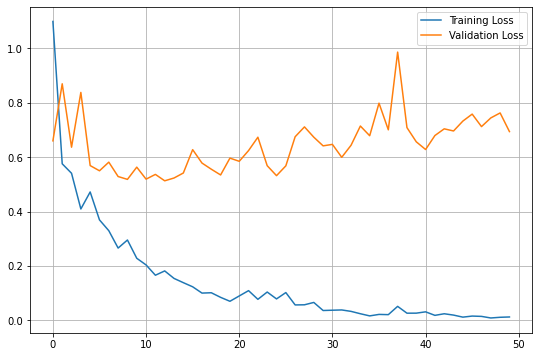

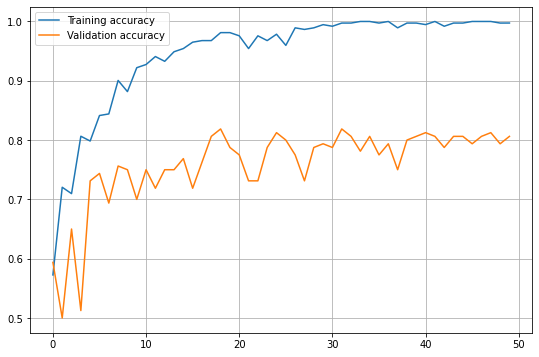

In [25]:
import matplotlib.pyplot as plt


plt.figure(figsize = (9, 6))
plt.plot( Hist.history['loss'])
plt.plot(Hist.history['val_loss'])

plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()


plt.figure(figsize = (9, 6))
plt.plot(Hist.history['accuracy'])
plt.plot( Hist.history['val_accuracy'])

plt.legend(['Training accuracy', 'Validation accuracy'])
plt.grid()
plt.show()

# 가중치 초기화 2번째(같은 모델)-값이 같은지 확인 

In [39]:
%%time

Hist = model.fit(train_generator, steps_per_epoch=38,
                epochs=50, validation_data=valid_generator, validation_steps=16) 

Epoch 1/50
38/38 [==============================] - 21s 472ms/step - loss: 1.3460 - accuracy: 0.5865 - val_loss: 1.6173 - val_accuracy: 0.4938
Epoch 2/50
38/38 [==============================] - 17s 455ms/step - loss: 0.7390 - accuracy: 0.6738 - val_loss: 0.6529 - val_accuracy: 0.5938
Epoch 3/50
38/38 [==============================] - 17s 446ms/step - loss: 0.5422 - accuracy: 0.7184 - val_loss: 0.9130 - val_accuracy: 0.4938
Epoch 4/50
38/38 [==============================] - 17s 436ms/step - loss: 0.4797 - accuracy: 0.7564 - val_loss: 0.6730 - val_accuracy: 0.5938
Epoch 5/50
38/38 [==============================] - 16s 433ms/step - loss: 0.3633 - accuracy: 0.8581 - val_loss: 0.9846 - val_accuracy: 0.4875
Epoch 6/50
38/38 [==============================] - 17s 436ms/step - loss: 0.4419 - accuracy: 0.8185 - val_loss: 0.5571 - val_accuracy: 0.7063
Epoch 7/50
38/38 [==============================] - 17s 441ms/step - loss: 0.3330 - accuracy: 0.8777 - val_loss: 0.5642 - val_accuracy: 0.6812

5/5 [==============================] - 1s 270ms/step - loss: 0.6394 - accuracy: 0.8600
0.6393934488296509 0.8600000143051147


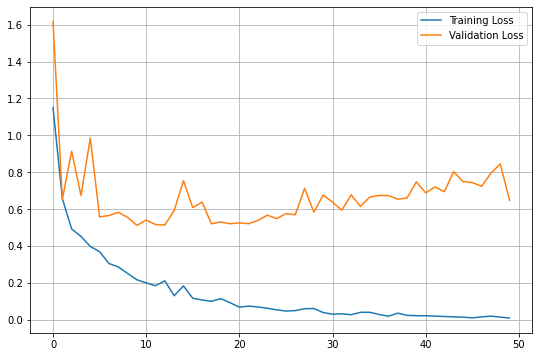

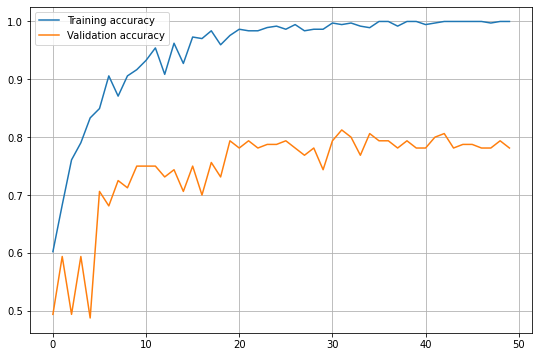

In [40]:
loss, accuracy = model.evaluate(valid_generator, steps=5)
print(loss, accuracy)

import matplotlib.pyplot as plt


plt.figure(figsize = (9, 6))
plt.plot( Hist.history['loss'])
plt.plot(Hist.history['val_loss'])

plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()


plt.figure(figsize = (9, 6))
plt.plot(Hist.history['accuracy'])
plt.plot( Hist.history['val_accuracy'])

plt.legend(['Training accuracy', 'Validation accuracy'])
plt.grid()
plt.show()

# batch_size= 50

In [26]:
from keras.preprocessing.image import ImageDataGenerator

# image directory
image_dir = '/content/img'

random_seed = 414

datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)

train_generator = datagen.flow_from_directory(image_dir,target_size = (640, 640), seed=random_seed,
                                                    batch_size = 50, class_mode = 'binary', subset='training')
valid_generator = datagen.flow_from_directory(image_dir, target_size=(640, 640), seed=random_seed,
                                              batch_size=50, class_mode='binary', subset='validation')


Found 382 images belonging to 2 classes.
Found 162 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50

conv_base =  ResNet50(weights='imagenet', include_top=False, input_shape =(640,640,3))

set_trainable = False

for layer in conv_base.layers:
    if layer.name =='conv5_block3_2_conv' :      
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

tf.keras.initializers.HeNormal()

from keras import layers, models, optimizers

model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid')) 

model.summary()

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.000005), metrics=['accuracy'])    

In [27]:
%%time

Hist = model.fit(train_generator, steps_per_epoch=382//50,
                epochs=50, validation_data=valid_generator, validation_steps=162//50) 

Epoch 1/50
7/7 [==============================] - 24s 3s/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.7132 - val_accuracy: 0.8067
Epoch 2/50
7/7 [==============================] - 15s 2s/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.8060 - val_accuracy: 0.7933
Epoch 3/50
7/7 [==============================] - 15s 2s/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.7446 - val_accuracy: 0.8200
Epoch 4/50
7/7 [==============================] - 15s 2s/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.7166 - val_accuracy: 0.8133
Epoch 5/50
7/7 [==============================] - 14s 2s/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.7551 - val_accuracy: 0.8067
Epoch 6/50
7/7 [==============================] - 15s 2s/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.8107 - val_accuracy: 0.7867
Epoch 7/50
7/7 [==============================] - 15s 2s/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.8119 - val_accuracy: 0.7867
Epoch 8/50
7/7 [==================

3/3 [==============================] - 5s 1s/step - loss: 0.6793 - accuracy: 0.6667
0.6793107390403748 0.6666666865348816


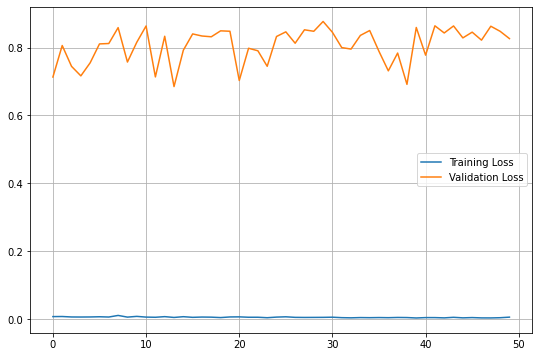

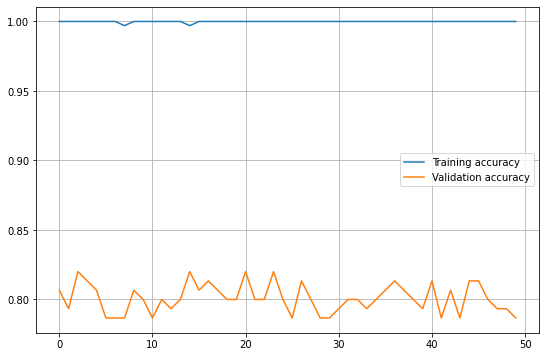

In [32]:
loss, accuracy = model.evaluate(valid_generator, steps=162//50)
print(loss, accuracy)

import matplotlib.pyplot as plt


plt.figure(figsize = (9, 6))
plt.plot( Hist.history['loss'])
plt.plot(Hist.history['val_loss'])

plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()


plt.figure(figsize = (9, 6))
plt.plot(Hist.history['accuracy'])
plt.plot( Hist.history['val_accuracy'])

plt.legend(['Training accuracy', 'Validation accuracy'])
plt.grid()
plt.show()